In [6]:
import os
import logging
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as u
from lenstools import ConvergenceMap
from scipy.ndimage import rotate
import math

In [2]:
nside = 8192 # Nside of the healpix map
patch_size = 10 # opening angle of the patch in degrees
xsize= 1024 # number of pixels in x direction
reso = patch_size*60/xsize # resolution of the map in arcmin
nbin= 15 # number of bins for snr calculation
lmin, lmax = 300, 3000 # ell range for spectrum calculation

bins = np.linspace(-4, 4, nbin+1, endpoint=True) # bins for snr calculation
l_edges = np.linspace(lmin, lmax, nbin+1, endpoint=True) # bins for spectrum calculation

In [7]:
# Function to generate a fibonacci grid on a sphere

def fibonacci_grid_on_sphere(N):
    """
    Generate an array of points on a Fibonacci grid on a sphere.

    Parameters:
    N (int): Number of points to distribute on the sphere.

    Returns:
    np.ndarray: Array of shape (N, 2) where each row contains (theta, phi) coordinates of a point.
    """
    points = np.zeros((N, 2))
    
    phi = (np.sqrt(5) + 1) / 2  # Golden ratio
    golden_angle = 2 * np.pi / phi
    
    for i in range(N):
        theta = np.arccos(1 - 2 * (i + 0.5) / N)
        phi = (golden_angle * i) % (2 * np.pi)
        points[i] = [theta, phi]
    
    return points



# Function to get pixel values inside a square patch
def get_patch_pixels(image, side_length):
    rotated_image = rotate(image, 45, reshape=False)

    x_center, y_center = rotated_image.shape[1]//2 , rotated_image.shape[0]//2
    half_side = side_length // 2

    x_start = max(x_center - half_side, 0)
    x_end = min(x_center + half_side, rotated_image.shape[1])
    
    y_start = max(y_center - half_side, 0)
    y_end = min(y_center + half_side, rotated_image.shape[0])
    
    patch_pixels = rotated_image[y_start:y_end, x_start:x_end]
    
    return patch_pixels

class patch_handler():
    def __init__(self, img, patch_size = 10, xsize = 1024, N=273, nest=True):
        self.img = img
        self.nest = nest

        self.patch_size = patch_size
        self.xsize = xsize
        self.reso = patch_size*60/xsize
        self.padding = 0.1 + np.sqrt(2)

        self.N = N
        self.points = fibonacci_grid_on_sphere(N)
        self.points_lonlatdeg = np.array([hp.rotator.vec2dir(hp.ang2vec(center[0], center[1]), lonlat=True) for center in self.points])

    def perform_patch(self):
        patchs = []
        for point in self.points_lonlatdeg:
            tmp_patch = hp.gnomview(self.img, nest=self.nest, rot=point, xsize=self.xsize*self.padding, reso=self.reso,return_projected_map=True, no_plot=True)
            patch_pixels = get_patch_pixels(tmp_patch, self.xsize)
            patchs.append(patch_pixels)

        self.patchs = np.array(patchs)

    def get_patch(self, i):
        return self.patchs[i]

In [3]:
fnames = sorted(glob("/lustre/work/Terawaki8128/Takahashi_simulation/lensingmap_fullsky_npy/kappa*.npy"))

# Load Data

In [43]:
sample = np.load(fnames[0])
sample2 = np.load(fnames[1])
sample3 = np.load(fnames[2])

nside = 8192


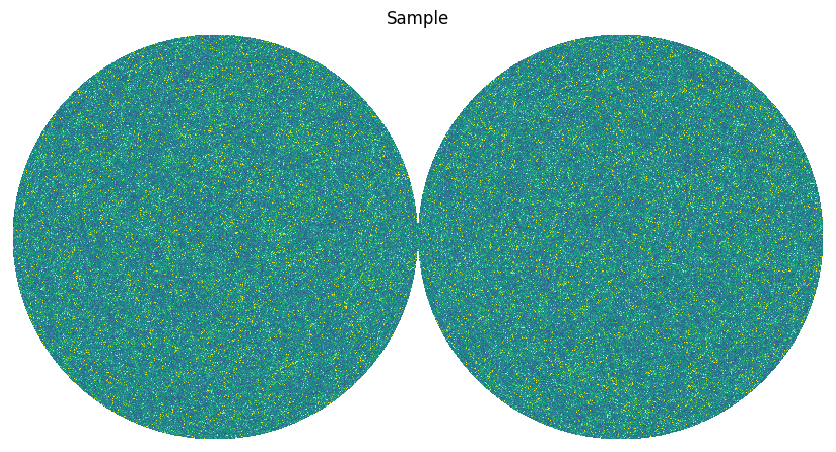

In [30]:
print("nside =", hp.npix2nside(len(sample)))
hp.orthview(sample, min=-0.06, max=0.06, title="Sample", cbar=False)

# Bispectrum Calculation

In [31]:
ph1 = patch_handler(sample, patch_size, xsize, N=250, nest=False)
ph1.perform_patch()

In [44]:
ph2 = patch_handler(sample2, patch_size, xsize, N=250, nest=False)
ph2.perform_patch()

In [45]:
ph3 = patch_handler(sample3, patch_size, xsize, N=250, nest=False)
ph3.perform_patch()

In [46]:
ells = []
bseqs = []

for img in ph1.patchs:
    tmp_conv = ConvergenceMap(data=img, angle=patch_size * u.deg)
    ell, bseq = tmp_conv.bispectrum(l_edges, configuration='equilateral')
    ells.append(ell)
    bseqs.append(bseq)

for img in ph2.patchs:
    tmp_conv = ConvergenceMap(data=img, angle=patch_size * u.deg)
    ell, bseq = tmp_conv.bispectrum(l_edges, configuration='equilateral')
    ells.append(ell)
    bseqs.append(bseq)

for img in ph3.patchs:
    tmp_conv = ConvergenceMap(data=img, angle=patch_size * u.deg)
    ell, bseq = tmp_conv.bispectrum(l_edges, configuration='equilateral')
    ells.append(ell)
    bseqs.append(bseq)

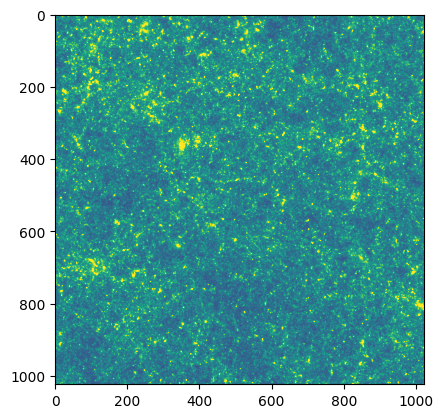

In [33]:
plt.imshow(ph1.patchs[1], vmin=-0.06, vmax=0.06)
plt.show()

In [39]:
ss = np.loadtxt("/lustre/work/sunao.sugiyama/fastnc/dev/bisepctrum_l_bkappa.dat")

In [41]:
l, b = ss[:,0], ss[:,1]

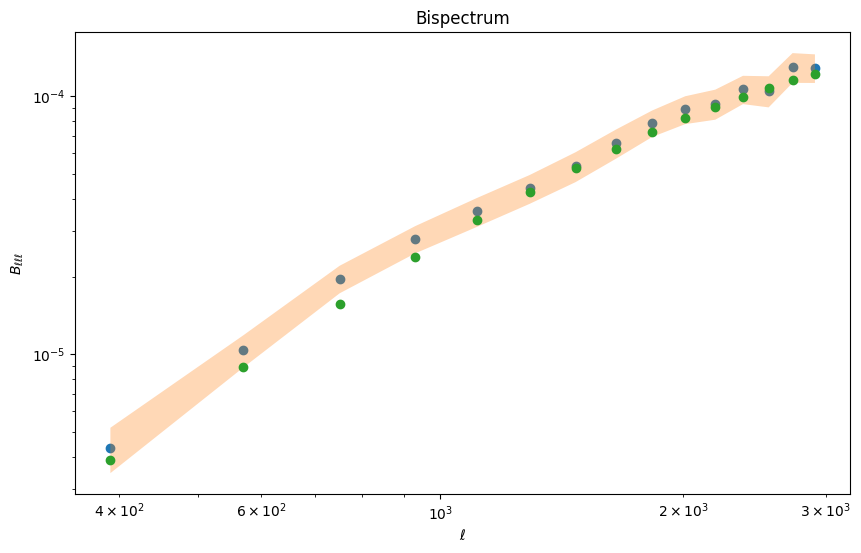

In [50]:
fig = plt.figure(figsize=(10, 6))
#for i in range(100):
#    plt.scatter(ells[i], ells[i]**4 * bseqs[i], label=f'Patch {i+1}')
plt.scatter(ells[0], ells[0]**4 * np.mean(bseqs, axis=0))
plt.fill_between(ells[0], ells[0]**4 * np.mean(bseqs, axis=0) - ells[0]**4 * np.std(bseqs, axis=0)/np.sqrt(250), ells[0]**4 * np.mean(bseqs, axis=0) + ells[0]**4 * np.std(bseqs, axis=0)/np.sqrt(250), alpha=0.3)
_ = np.interp(ells[0], l, b)
plt.scatter(ells[0], ells[0]**4 * _, label='FastPM')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$B_{\ell\ell\ell}$')
plt.title('Bispectrum')
plt.show()

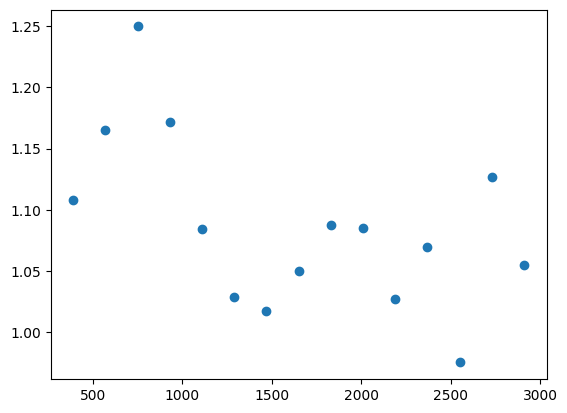

In [52]:
plt.scatter(ells[0], np.mean(bseqs, axis=0)/_)